In [ ]:
import pandas as pd # for data manipulation and analysis
import numpy as np

import seaborn as sns # for data visualization
import matplotlib.pyplot as plt
import plotly.express as px

# import dash # for building interactive visualizations
# from dash import dcc, html, Input, Output

import geopandas as gpd # for geographic data manipulation
from shapely.geometry import Point, Polygon

from sklearn.model_selection import train_test_split # for machine learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## 1. Data Preparation

In [ ]:
file_path_1 = '/content/drive/MyDrive/CSCI 636/MTA_Subway_Hourly_Ridership__Beginning_February_2022.csv'
file_path_2 = '/content/drive/MyDrive/CSCI 636/MTA_Subway_Hourly_Ridership__Beginning_February_2022_pt3.csv'
file_path_3 = '/content/drive/MyDrive/CSCI 636/MTA_Subway_Hourly_Ridership__Beginning_February_2022_pt4.csv'
file_path_4 = '/content/drive/MyDrive/CSCI 636/MTA_Subway_Hourly_Ridership__Beginning_February_2022_pt2.csv'

file_paths = [file_path_1, file_path_2, file_path_3, file_path_4]

# Read each file into a separate DataFrame
data_frames = [pd.read_csv(file_path, low_memory=False) for file_path in file_paths]

# Concatenate the DataFrames
df = pd.concat(data_frames)

## 2. Data Cleaning

In [ ]:
# change transit_timestamp to datetime object
df['transit_timestamp'] = pd.to_datetime(df['transit_timestamp'])

In [ ]:
#Make a copy before slicing the dataset
# original_df = df.copy()

In [ ]:
# check the earliest and latest time of the data
print(df['transit_timestamp'].min())
print(df['transit_timestamp'].max())

2022-02-01 00:00:00
2024-02-29 23:00:00


Since the data begins on February 1st 2022, we will use the data from Feb 2022 → Feb 2024.

This will allow us to have an even distribution and outliers such as holiday will only occur once in the data.

In [ ]:
# prompt: check which column contain NaN number. remove column with NaN values

# Check for NaN values in each column
df.isnull().sum()
# Drop columns with NaN values
df.dropna(axis=1, inplace=True)

In [ ]:
# Check is there is any NaN values
df.isnull().sum()

transit_timestamp     0
station_complex_id    0
station_complex       0
borough               0
payment_method        0
ridership             0
transfers             0
latitude              0
longitude             0
Georeference          0
dtype: int64

In [ ]:
df.head()

,transit_timestamp,station_complex_id,station_complex,borough,payment_method,ridership,transfers,latitude,longitude,Georeference
0,2022-06-24 04:00:00,H007,1 Av (L),M,omny,19,0,40.730953,-73.981628,POINT (-73.98162841796875 40.730953216552734)
1,2022-07-05 22:00:00,H007,1 Av (L),M,omny,229,0,40.730953,-73.981628,POINT (-73.98162841796875 40.730953216552734)
2,2022-08-30 03:00:00,H007,1 Av (L),M,omny,5,0,40.730953,-73.981628,POINT (-73.98162841796875 40.730953216552734)
3,2022-11-05 03:00:00,H007,1 Av (L),M,omny,78,0,40.730953,-73.981628,POINT (-73.98162841796875 40.730953216552734)
4,2023-01-19 04:00:00,H007,1 Av (L),M,omny,5,0,40.730953,-73.981628,POINT (-73.98162841796875 40.730953216552734)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22546693 entries, 0 to 7417775
Data columns (total 10 columns):
 #   Column              Dtype         
---  ------              -----         
 0   transit_timestamp   datetime64[ns]
 1   station_complex_id  object        
 2   station_complex     object        
 3   borough             object        
 4   payment_method      object        
 5   ridership           int64         
 6   transfers           int64         
 7   latitude            float64       
 8   longitude           float64       
 9   Georeference        object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(5)
memory usage: 1.8+ GB


In [ ]:
df.shape

(22546693, 10)

In [ ]:
# prompt: save new df to csv file with cleaned data
# df.to_csv('/content/drive/MyDrive/CSCI 636/MTA_data_combined.csv')

In [ ]:
# prompt: get unique values of column borough. update value M into Manhattan, Q to Queens, BK to Brooklyn, BX to Bronx, SI to Staten Island

df['borough'].replace({'M': 'Manhattan', 'Q': 'Queens', 'BK': 'Brooklyn', 'BX': 'Bronx', 'SI': 'Staten Island'}, inplace=True)


In [ ]:
# prompt: get unique values of column borough.
unique_boroughs = df['borough'].unique()
print(unique_boroughs)

['Manhattan' 'Queens' 'Brooklyn' 'Bronx' 'Staten Island']


In [ ]:
df.head()

,transit_timestamp,station_complex_id,station_complex,borough,payment_method,ridership,transfers,latitude,longitude,Georeference
0,2022-06-24 04:00:00,H007,1 Av (L),Manhattan,omny,19,0,40.730953,-73.981628,POINT (-73.98162841796875 40.730953216552734)
1,2022-07-05 22:00:00,H007,1 Av (L),Manhattan,omny,229,0,40.730953,-73.981628,POINT (-73.98162841796875 40.730953216552734)
2,2022-08-30 03:00:00,H007,1 Av (L),Manhattan,omny,5,0,40.730953,-73.981628,POINT (-73.98162841796875 40.730953216552734)
3,2022-11-05 03:00:00,H007,1 Av (L),Manhattan,omny,78,0,40.730953,-73.981628,POINT (-73.98162841796875 40.730953216552734)
4,2023-01-19 04:00:00,H007,1 Av (L),Manhattan,omny,5,0,40.730953,-73.981628,POINT (-73.98162841796875 40.730953216552734)


In [ ]:
# df.to_csv('/content/drive/MyDrive/CSCI 636/MTA_data_combined.csv')

Clean the names of the stations by removing the route numbers

In [ ]:
# remove the () and everything in between the () from each station_complex row in the df
df['station_complex'] = df['station_complex'].str.replace(r'\(.*\)', '', regex=True)

In [ ]:
df.head()

,transit_timestamp,station_complex_id,station_complex,borough,payment_method,ridership,transfers,latitude,longitude,Georeference
0,2022-06-24 04:00:00,H007,1 Av,Manhattan,omny,19,0,40.730953,-73.981628,POINT (-73.98162841796875 40.730953216552734)
1,2022-07-05 22:00:00,H007,1 Av,Manhattan,omny,229,0,40.730953,-73.981628,POINT (-73.98162841796875 40.730953216552734)
2,2022-08-30 03:00:00,H007,1 Av,Manhattan,omny,5,0,40.730953,-73.981628,POINT (-73.98162841796875 40.730953216552734)
3,2022-11-05 03:00:00,H007,1 Av,Manhattan,omny,78,0,40.730953,-73.981628,POINT (-73.98162841796875 40.730953216552734)
4,2023-01-19 04:00:00,H007,1 Av,Manhattan,omny,5,0,40.730953,-73.981628,POINT (-73.98162841796875 40.730953216552734)


## 3. Exploratory Data Analysis

EDA steps was completed by Tablaeu. Show all findings at [link](https://public.tableau.com/app/profile/lam.nguyen6169/viz/CSCI-636-Viz/Dashboard1)

## 4. Prediction Ridership

If we can create a model to predict ridership at any given time, this would be an incredibly useful tool for the MTA to use. This would allow them to better plan for maintenance, staffing, and other resources. This data set is limited to only a few factors that could affect ridership, but it is a good starting point and will indicate if it is possible to create a model to predict ridership.

I chose to use Random Forest Regression for this task because we needed to choose a model that can handle non-linear data and it is not prone to overfitting.

In [ ]:
# make a new dataframe called rfr_df
model_df = pd.DataFrame()

In [ ]:
model_df['month'] = df['transit_timestamp'].dt.month
model_df['day'] = df['transit_timestamp'].dt.day
model_df['hour'] = df['transit_timestamp'].dt.hour
model_df['ridership'] = df['ridership']

model_df = model_df.groupby(['month', 'day', 'hour'])['ridership'].sum().reset_index()

model_df.head()

,month,day,hour,ridership
0,1,1,0,154886
1,1,1,1,143323
2,1,1,2,85488
3,1,1,3,44117
4,1,1,4,28826


### Splitting data for training and testing

In [ ]:
X = model_df[['month', 'day', 'hour']]
y = model_df['ridership']

# Split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Split the data into features and labels
labels = np.array(model_df['ridership'])
features = model_df.drop('ridership', axis=1)
feature_list = list(features.columns)
features = np.array(features)

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, test_size=0.25, random_state=38
)

### Random Forest Regressor

Mean Absolute Error: 51127.85 riders.
R-squared (R2): 0.8
Accuracy: 74.46 %.


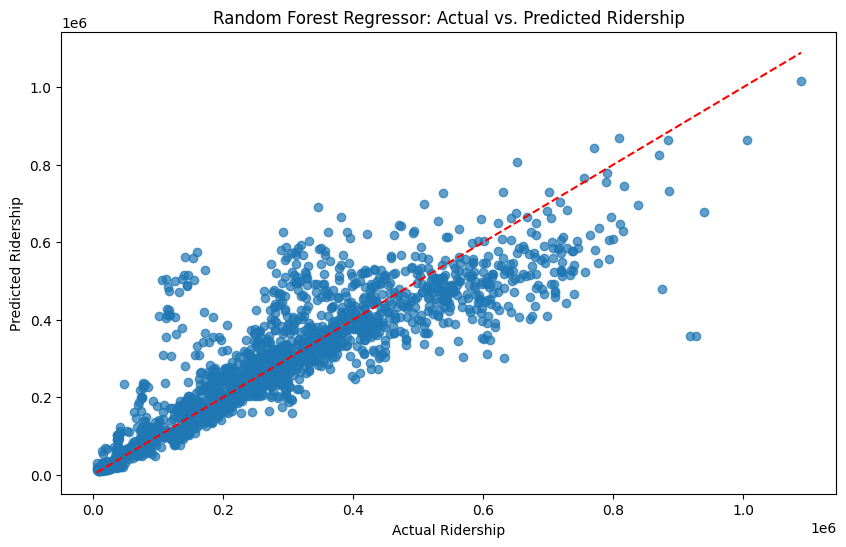

In [ ]:
# Instantiate model with decision trees
rf = RandomForestRegressor(n_estimators=400, random_state=38)

# Train the model on training data
rf.fit(train_features, train_labels)

# Make predictions on the test set
predictions = rf.predict(test_features)

# Calculate the absolute errors
errors = abs(predictions - test_labels)

# Print out the mean absolute error (MAE)
mae = mean_absolute_error(test_labels, predictions)
print('Mean Absolute Error:', round(mae, 2), 'riders.')

# Calculate the R-squared (R2)
r2 = r2_score(test_labels, predictions)
print('R-squared (R2):', round(r2, 2))

# Calculate and display Mean Absolute Percentage Error (MAPE) and Accuracy
mape = 100 * (errors / test_labels)
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

# Create a scatter plot to visualize the predictions vs. actual values
plt.figure(figsize=(10, 6))
plt.scatter(test_labels, predictions, alpha=0.7)
plt.plot([min(test_labels), max(test_labels)], [min(test_labels), max(test_labels)], 'r--')

plt.xlabel('Actual Ridership')
plt.ylabel('Predicted Ridership')
plt.title('Random Forest Regressor: Actual vs. Predicted Ridership')
plt.show()

Based on the results obtained from the random forest regressor model, it's evident that the model performs moderately well. The Mean Absolute Error (MAE) of 51127.85 riders indicates that, on average, the model's predictions deviate from the actual values by this amount. While the MAE is relatively high, suggesting some level of inconsistency in prediction accuracy, it's crucial to consider the context of the problem domain.

The R-squared (R2) value of 0.8 implies that approximately 80% of the variance in the target variable is explained by the model, indicating a reasonably good fit to the data. However, there may still be room for improvement in capturing more of the variance.

The accuracy metric of 74.46% suggests that the model is able to predict the target variable correctly about three-quarters of the time. This is a decent level of accuracy, although it may not be sufficient depending on the specific requirements of the application.

In conclusion, while the random forest regressor model demonstrates respectable performance, there is potential for enhancement, particularly in reducing the Mean Absolute Error and possibly improving accuracy further. Fine-tuning the model hyperparameters or exploring different algorithms could be avenues for improving predictive performance.

What are the most important features in our model?

month: 0.09260255137229755
day: 0.12420005391153656
hour: 0.7831973947161659


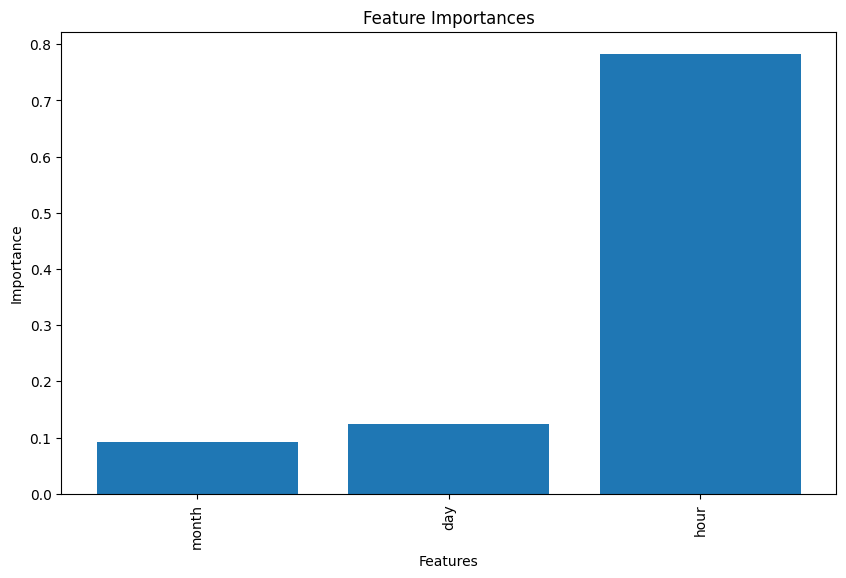

In [ ]:
# Train the model on training data
rf.fit(train_features, train_labels)

# Get feature importances
feature_importances = rf.feature_importances_

# Associate feature importances with feature names
feature_importance_list = list(zip(feature_list, feature_importances))

# Print the top N most important features and their importances
for feature, importance in feature_importance_list:
    print(f"{feature}: {importance}")

# Create a bar plot to visualize feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances)
plt.xticks(range(len(feature_importances)), [feature[0] for feature in feature_importance_list], rotation='vertical')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()


**The hour of day is a major indicator on the amount of ridership**

Function for predicting ridership

In [ ]:
def predict_and_show_ridership(month, day, hour):
    input_data = np.array([[month, day, hour]])
    predicted_ridership = rf.predict(input_data)
    actual_ridership = model_df[(model_df['month'] == month) & (model_df['day'] == day) & (model_df['hour'] == hour)]['ridership'].values[0]

    print(f"Input: Month={month}, Day={day}, Hour={hour}")
    print(f"Predicted Ridership: {round(predicted_ridership[0], 2)}")
    print(f"Actual Ridership: {actual_ridership}")

In [ ]:
# Test the function with a specific input
predict_and_show_ridership(month=5, day=5, hour=12)

Input: Month=5, Day=5, Hour=12
Predicted Ridership: 292739.44
Actual Ridership: 299949


In [ ]:
predict_and_show_ridership(month=3, day=27, hour=2)

Input: Month=3, Day=27, Hour=2
Predicted Ridership: 16202.57
Actual Ridership: 15305


### Gradient Boosting Regressor

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score

Mean Absolute Error: 54168.78 riders.
R-squared (R2): 0.8
Accuracy: 66.69 %.


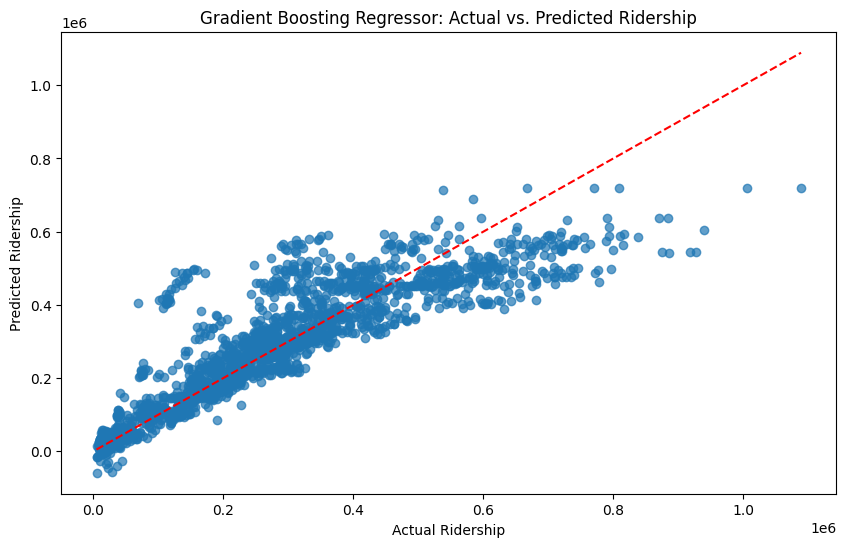

In [ ]:
# Instantiate Gradient Boosting Regressor model
gb_regressor = GradientBoostingRegressor(random_state=42)

# Train the model on training data
gb_regressor.fit(train_features, train_labels)

# Make predictions on the test set
predictions = gb_regressor.predict(test_features)

# Calculate the absolute errors
errors = abs(predictions - test_labels)

# Print out the mean absolute error (MAE)
mae = mean_absolute_error(test_labels, predictions)
print('Mean Absolute Error:', round(mae, 2), 'riders.')

# Calculate the R-squared (R2)
r2 = r2_score(test_labels, predictions)
print('R-squared (R2):', round(r2, 2))

# Calculate and display Mean Absolute Percentage Error (MAPE) and Accuracy
mape = 100 * (errors / test_labels)
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

# Create a scatter plot to visualize the predictions vs. actual values
plt.figure(figsize=(10, 6))
plt.scatter(test_labels, predictions, alpha=0.7)
plt.plot([min(test_labels), max(test_labels)], [min(test_labels), max(test_labels)], 'r--')

plt.xlabel('Actual Ridership')
plt.ylabel('Predicted Ridership')
plt.title('Gradient Boosting Regressor: Actual vs. Predicted Ridership')
plt.show()

Mean Absolute Error (MAE): The MAE of 54168.78 riders represents the average absolute difference between the predicted values and the actual values. In this case, on average, the predictions deviate from the true values by approximately 54168.78 riders. Lower values of MAE indicate better performance, so while this value is not extremely low, it does provide an indication of how close the model's predictions are to the actual values.

R-squared (R2): The R-squared value of 0.8 indicates that approximately 80% of the variance in the target variable is explained by the model. This means that the model captures a significant portion of the variability in the data and is able to explain a large proportion of the variance in the ridership. R-squared values range from 0 to 1, where 1 represents a perfect fit. Therefore, an R-squared value of 0.8 suggests a relatively good fit of the model to the data.

Accuracy: It's unusual to talk about accuracy in the context of regression problems, as accuracy is typically used in classification tasks. However, if you're using accuracy here as a measure of how often the predictions fall within a certain threshold of the actual values, then the reported accuracy of 66.69% suggests that approximately two-thirds of the predictions are within the acceptable threshold of the true values. This indicates a moderate level of predictive accuracy.

In summary, the Gradient Boosting Regressor model demonstrates reasonably good performance, as indicated by the relatively low MAE, high R-squared value, and moderate accuracy. However, there may still be room for improvement in reducing the MAE and potentially increasing the accuracy of predictions further. Fine-tuning hyperparameters or exploring other regression algorithms could be avenues for enhancing predictive performance.

## Conclusion

**This analysis has successfully shown that many of the potential goals of the analysis can be answered using data**

**Schedule maintenance and improve crowd management**
This analysis shows we can easily determine the trends for which stations, time of day and day of the week have the most riders. This information can be used to schedule maintenance and improve crowd management. We did this through bar charts, strip plots, and treemaps.

**Ridership by location**
It is also clear that by using geovisualization and exploratory data analysis techniques, we can see which boroguhs and stations have the most riders. The heatmap and dash app are great tools to visualize this data.

**Predicting Ridership**
We were able to predict ridership with a high degree of accuracy. This shows that there is potential to build a model to predict ridership. I believe that given the right data, this model could be improved and reliably predict how many riders will be at a given station at a given time.